# Predicting Bacterial Pathogeny using Chaos Game Representations of genomes

## Setup

In [135]:
import numpy as np
import os
import utilities as utils
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

import gc # to clear memory

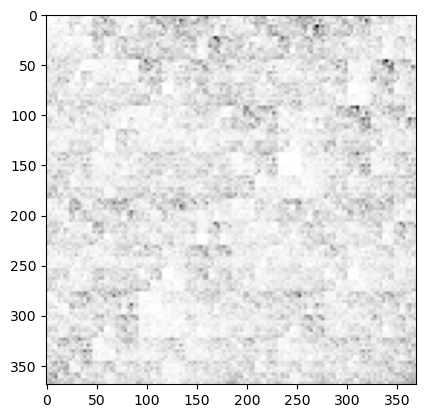

In [95]:
plt.imshow(1-utils.read_cgr_plot('plots/patho/1.png')/255, cmap='gray_r')

## Data Engineering

### Feature Extraction

In [103]:
dataset = 'patho_repr'

In [104]:
print('Generating pathogenic CGR matrices ...')
#labels = []
cgr_mats = []
seqs = []
patho_labs = []
for dir1 in [dir for dir in os.listdir(dataset) if not dir.startswith('.')]:
    for file in os.listdir(os.path.join(dataset, dir1)):
        path_to_file = os.path.join(dataset,dir1,file)
        sequence = utils.read_sequence(path_to_file)
        if len(sequence) < 8000:
            continue
        seqs.append(sequence)
        #sequence_reverse_complement = utils.reverse_complement(sequence)
        tmp = utils.cgr(sequence, 'ACGT', 7)
        cgr_mats.append(tmp)
        #labels.append(path_to_file.split('/')[1])
        patho_labs.append(1)

"""cgr_mats = cgr_mats[:30]
patho_labs = patho_labs[:30]
seqs = seqs[:30]"""
patho_ln = np.array(patho_labs).shape[0]
print(f'{patho_ln} pathogenic CGR matrices were generated.')


Generating pathogenic CGR matrices ...
94 pathogenic CGR matrices were generated.


In [105]:
dataset = 'non_repr'

In [106]:
print('Generating non-pathogenic CGR matrices ...')
for dir1 in [dir for dir in os.listdir(dataset) if not dir.startswith('.')]:
    for file in os.listdir(os.path.join(dataset, dir1)):
        path_to_file = os.path.join(dataset,dir1,file)
        sequence = utils.read_sequence(path_to_file)
        if len(sequence) < 8000:
            continue
        seqs.append(sequence)
        #sequence_reverse_complement = utils.reverse_complement(sequence)
        tmp = utils.cgr(sequence, 'ACGT', 7)
        cgr_mats.append(tmp)
        #labels.append(path_to_file.split('/')[1])
        patho_labs.append(0)
non_patho_ln = np.array(patho_labs).shape[0]-patho_ln
print(f'{non_patho_ln} non-pathogenic CGR matrices were generated.')
print(f'{np.array(patho_labs).shape[0]} total CGR matrices were generated.')

Generating non-pathogenic CGR matrices ...
26 non-pathogenic CGR matrices were generated.
120 total CGR matrices were generated.


In [107]:
print('Normalizing and vectorizing CGR plots ...')
normalized_mats = [mat/np.max(mat) for mat in cgr_mats]
vector_cgrs = [mat.flatten() for mat in normalized_mats]

Normalizing and vectorizing CGR plots ...


In [108]:
print('Generating CGR plots ...')
plt.clf()
for i, mat in enumerate(normalized_mats):
    plt.imshow(mat, aspect='auto', cmap='gray_r', extent=[0, mat.shape[1], mat.shape[0], 0])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.axis('off')
    if i < patho_ln:
        plt.savefig(f'./plots/patho/{i+1}.png',  bbox_inches='tight', pad_inches=0)
    else:
        j = i-patho_ln
        plt.savefig(f'./plots/non_patho/{j+1}.png', bbox_inches='tight', pad_inches=0)
    plt.close()

Generating CGR plots ...


In [109]:
dataset = 'plots'

In [110]:
print('Reading CGR Plots ...')
#labels = []
cgr_mats = []
patho_labs = []
for dir1 in [dir for dir in os.listdir(dataset) if not dir.startswith('.')]:
    for file in [f for f in os.listdir(os.path.join(dataset, dir1)) if not f.startswith('.')]:
        path_to_file = os.path.join(dataset,dir1,file)
        tmp = utils.read_cgr_plot(path_to_file)
        cgr_mats.append(tmp)
        if dir1=='patho':
            patho_labs.append(1)
        elif dir1=='non_patho':
            patho_labs.append(0)
print(f'{np.array(patho_labs).shape[0]} CGR plots were loaded')

Reading CGR Plots ...
120 CGR plots were loaded


In [111]:
D = pairwise_distances(vector_cgrs, metric='manhattan')

In [112]:
np.all(np.diag(D) == 0)

True

In [113]:
np.all(D == D.T)

True

In [114]:
reduced = utils.perform_mds(D, 3, random_state=0)

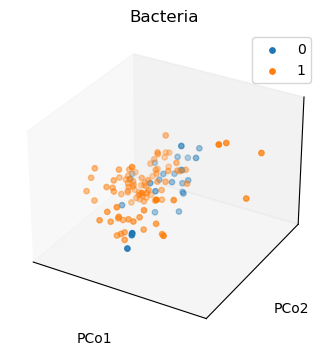

In [115]:
utils.plot_3d(reduced, patho_labs)

In [116]:
print('Normlaizing features s.t. mean=0, sd=1')
normalized_mats = [(mat-np.mean(mat))/np.std(mat) for mat in cgr_mats]
vector_cgrs = [mat.flatten() for mat in normalized_mats]
vector_cgrs = np.array([mat.flatten() for mat in normalized_mats])

Normlaizing features s.t. mean=0, sd=1


In [117]:
print('Performing Principal Component Analysis ...')
pca = PCA(n_components=3)
pca.fit(vector_cgrs)
transformed_data = pca.transform(vector_cgrs)
comp1 = transformed_data[:, 0]

Performing Principal Component Analysis ...


In [118]:
print('Initializing the model (Random Forest) ...')
clf_rf = RandomForestClassifier(criterion='gini',max_depth=3)
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True)

Initializing the model (Random Forest) ...


In [122]:
print('K-Fold evaluation ...')
accs_rf = []
for train_i, test_j in kf.split(vector_cgrs):
    X_train, X_test = vector_cgrs[train_i], vector_cgrs[test_j]
    y_train, y_test = np.array(patho_labs)[train_i], np.array(patho_labs)[test_j]
    clf_rf.fit(X_train, y_train)
    y_preds = clf_rf.predict(X_test)
    accuracy = 100*accuracy_score(y_test, y_preds)
    accs_rf.append(accuracy)
for i,score in enumerate(accs_rf):
    print(f'Fold {i+1}: {score}')
print(f'Model accuracy: {np.mean(accs_rf)}')

K-Fold evaluation ...
Fold 1: 100.0
Fold 2: 91.66666666666666
Fold 3: 83.33333333333334
Fold 4: 83.33333333333334
Fold 5: 91.66666666666666
Fold 6: 100.0
Fold 7: 83.33333333333334
Fold 8: 83.33333333333334
Fold 9: 100.0
Fold 10: 75.0
Model accuracy: 89.16666666666667


In [147]:
print('Splitting the dataset (test_size=20%) ...')
X_tr, X_t, y_tr, y_t = train_test_split(vector_cgrs, patho_labs, test_size=.20)

Splitting the dataset (test_size=20%) ...


In [148]:
print('Training the model ...')
clf_rf.fit(X_tr, y_tr)

Training the model ...


RandomForestClassifier(max_depth=3)

In [149]:
print('Predicting pathogeny on testing data ...')
preds = clf_rf.predict(X_t)

Predicting pathogeny on testing data ...


Displaying confusion matrix: 


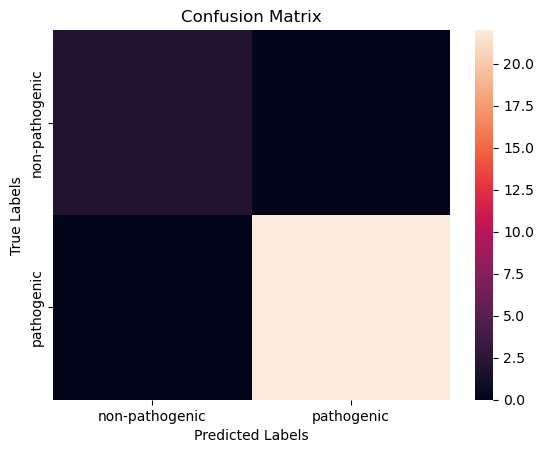

In [159]:
print('Displaying confusion matrix: ')
labs = ['non-pathogenic', 'pathogenic']
cm = confusion_matrix(y_t, preds)
sns.heatmap(cm, xticklabels=labs, yticklabels=labs)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [160]:
print(np.mean(accs_rf))

89.16666666666667
